To connect to a dockerized Jupyter server with PySpark configured:  
- ```docker pull jupyter/pyspark-notebook``` 
- ```docker run -it -p 8888:8888 -v /your/host/directory:/home/jovyan/work --name your_container_name jupyter/pyspark-notebook``` 
- to use plotly: ```docker exec your_container pip install plotly```

# Spark meets BART Ridership Data

**This notebook contains a mini playground project using Spark DataFrames with BART ridership data from 2015 to 2018. Benefits of running Spark on a single node with a small dataset (40 million records in this case) are limited, but it was a fun way to get to learn Spark DataFrame basics for a Spark newbie like myself.** <br>


Raw data used in this project can be found from BART's data portal [here](http://64.111.127.166/origin-destination/). <br>

Each .csv file from the data source is compressed into a gz/gzip archive and contains five columns representing Day, Hour, Origin Station, Destination Station, and Trip Count. The hourly BART ridership data from 2015 to 2018 contains origin/destination pair passenger activities among BART stations. For a list of station names visit [here](https://www.bart.gov/sites/default/files/docs/Station_Names.xls). The Stations_with_xy.csv file used in this notebook was prepared using the stations list downloaded from the BART data portal. I used Google Maps Geocoding API to geocode each station, but we can also grab station coordinates from BART's Station Information API (http://api.bart.gov/docs/stn/index.aspx). If using the BART station Information API, note that there is a mismtach between Antioch and Warm Spring's API pulled station code and the station code used in the raw data file. 

# Import packages and create Spark session

In [4]:
import os
import pandas as pd
import numpy as np
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pyspark.sql import SparkSession 
from pyspark.sql.types import *

%matplotlib inline
plt.style.use('ggplot')

# Create a Spark Session 
spark = SparkSession.builder.appName("BART_Pyspark").getOrCreate()
spark.sparkContext

<SparkContext master=local[*] appName=BART_Pyspark>

In [5]:
import plotly.graph_objects as go

# Load BART Ridership data to Spark DataFrame

#### Load data to Spark DataFrame
- Thanks to lazy evaluation, Spark DataFrame "loads" the dataset 700 times faster than pandas DataFrame in this case.

In [6]:
# set up file path
file_path_ridership = '/home/jovyan/work/'
file_name_ridership = 'BART_riderip_15_to_18'
input_data_ridership = os.path.join(file_path_ridership, file_name_ridership+'.csv')

file_path_stations = '/home/jovyan/work/'
file_name_stations = 'Stations_with_xy'
input_data_stations = os.path.join(file_path_stations, file_name_stations+'.csv')

# impose schema
schema_ridership = StructType([
    StructField('Date', DateType(), True),
    StructField('Hour', IntegerType(), True),
    StructField('Origin', StringType(), True),
    StructField('Destination', StringType(), True),
    StructField('Counts', IntegerType(), True)
])

schema_stations = StructType([
    StructField('station_name', StringType(), True),
    StructField('lat', FloatType(), True),
    StructField('lon', FloatType(), True),
    StructField('address', StringType(), True),
    StructField('sta_code', StringType(), True)
])

# load data to Spark DataFrame
ridership_15_18 = spark.read.csv(input_data_ridership, header=True, schema=schema_ridership)
stations = spark.read.csv(input_data_stations, header=True, schema=schema_stations)

# Alternatively, we could do:
# ridership_15_18 = spark.read.format('csv').option('header', 'true').load(input_data, schema=schema_ridership)

#### Load data to pandas df (to feel the difference)

In [7]:
'''
file_path = '/home/jovyan/work/'
file_name = 'BART_riderip_15_to_18'
input_data = os.path.join(file_path, file_name+'.csv')

ridership_15_18_pd = pd.read_csv(
    input_data, header=None, 
    names=['Date', 'Hour', 'Origin', 'Destination', 'Counts'], 
    parse_dates=['Date']
)
'''
pass

# Preliminary interactions with the Spark DataFrame

#### To make sure we have captured the data types of each column

In [8]:
ridership_15_18.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Counts: integer (nullable = true)



#### How many records do we have? 

In [9]:
ridership_15_18.count()

40093597

#### Take a sample set from the base DataFrame
- As an example here, I took a 10% sample of all origin/destination pairs with San Bruno being the origin station

In [13]:
# .sample(withReplacement, fraction, seed)

s1 = ridership_15_18.filter("Origin = 'SBRN'").sample(False, 0.1, 60)
s1.show(5)
s1.count()

+----------+----+------+-----------+------+
|      Date|Hour|Origin|Destination|Counts|
+----------+----+------+-----------+------+
|2015-01-01|   1|  SBRN|       BALB|     1|
|2015-01-01|   2|  SBRN|       SBRN|     1|
|2015-01-01|  10|  SBRN|       BALB|     3|
|2015-01-01|  10|  SBRN|       EMBR|    11|
|2015-01-01|  10|  SBRN|       POWL|    12|
+----------+----+------+-----------+------+
only showing top 5 rows



69841

#### Let's extract year, month, and day of week from Date and add three new columns to the Saprk Dataframe
*Spark DataFrame is immutable
- year
- month
- day_of_week (**note here 1 = Sunday, 2 = Monday, ..., 7 = Saturday**)

In [14]:
ridership_15_18.withColumn(
    'year', f.year('Date')
).withColumn(
    'month',  f.from_unixtime(f.unix_timestamp('Date'), 'MMMMM')
).withColumn(
    'day_of_week', f.dayofweek('Date')
).show(5)

+----------+----+------+-----------+------+----+-------+-----------+
|      Date|Hour|Origin|Destination|Counts|year|  month|day_of_week|
+----------+----+------+-----------+------+----+-------+-----------+
|2015-01-01|   0|  12TH|       12TH|     1|2015|January|          5|
|2015-01-01|   0|  12TH|       16TH|     1|2015|January|          5|
|2015-01-01|   0|  12TH|       24TH|     3|2015|January|          5|
|2015-01-01|   0|  12TH|       ASHB|     6|2015|January|          5|
|2015-01-01|   0|  12TH|       BALB|     3|2015|January|          5|
+----------+----+------+-----------+------+----+-------+-----------+
only showing top 5 rows



#### Building upon the previous step, let's filter the data to operating hours specified below
- **Mon - Fri** 5AM to mid-night
- **Sat** 6AM to mid-night
- **Sun** 8AM to mid-night

In [15]:
ridership_15_18.withColumn(
    'year', f.year('Date')
).withColumn(
    'month', f.from_unixtime(f.unix_timestamp('Date'), 'MMMMM')
).withColumn(
    'day_of_week', f.dayofweek('Date')
).filter("""
    ((day_of_week BETWEEN 2 AND 6) AND (Hour >= 5))
    OR
    ((day_of_week = 1) AND (Hour >= 8))
    OR
    ((day_of_week = 7) AND (Hour >= 6))"""
).show(5)

+----------+----+------+-----------+------+----+-------+-----------+
|      Date|Hour|Origin|Destination|Counts|year|  month|day_of_week|
+----------+----+------+-----------+------+----+-------+-----------+
|2015-01-01|   5|  12TH|       LAKE|     1|2015|January|          5|
|2015-01-01|   5|  16TH|       SFIA|     3|2015|January|          5|
|2015-01-01|   5|  19TH|       SFIA|     2|2015|January|          5|
|2015-01-01|   5|  CIVC|       SFIA|     2|2015|January|          5|
|2015-01-01|   5|  DUBL|       MONT|     1|2015|January|          5|
+----------+----+------+-----------+------+----+-------+-----------+
only showing top 5 rows



#### Building upon the previous step, let's swap day_of_week values with day of week names and save data to a new DataFrame called  <font color='red'> ridership_15_18_operating </font>

In [16]:
ridership_15_18_operating = ridership_15_18.withColumn(
    'year', f.year('Date')
).withColumn(
    'month', f.from_unixtime(f.unix_timestamp('Date'), 'MMMMM')
).withColumn(
    'day_of_week', f.dayofweek('Date')
).filter("""
    ((day_of_week BETWEEN 2 AND 6) AND (Hour >= 5))
    OR
    ((day_of_week = 1) AND (Hour >= 8))
    OR
    ((day_of_week = 7) AND (Hour >= 6))"""
).withColumn(
    'day_of_week', f.from_unixtime(f.unix_timestamp('Date'), 'EEEE')
)

ridership_15_18_operating.show(5)

+----------+----+------+-----------+------+----+-------+-----------+
|      Date|Hour|Origin|Destination|Counts|year|  month|day_of_week|
+----------+----+------+-----------+------+----+-------+-----------+
|2015-01-01|   5|  12TH|       LAKE|     1|2015|January|   Thursday|
|2015-01-01|   5|  16TH|       SFIA|     3|2015|January|   Thursday|
|2015-01-01|   5|  19TH|       SFIA|     2|2015|January|   Thursday|
|2015-01-01|   5|  CIVC|       SFIA|     2|2015|January|   Thursday|
|2015-01-01|   5|  DUBL|       MONT|     1|2015|January|   Thursday|
+----------+----+------+-----------+------+----+-------+-----------+
only showing top 5 rows



#### Get summary statistics for riders travelling from Castro Valley to Montgomery on Wednesdays duing morning peak hours in 2018 

In [17]:
ridership_15_18_operating.filter(
    "Origin = 'CAST' \
     AND Destination = 'MONT' \
     AND day_of_week = 'Wednesday' \
     AND year = 2018 \
     AND Hour IN (7, 8, 9)"
).describe('Counts').show()
# 155 such pairs/records in the dataset
# on average, 128 riders made such trip each hour, with a stddev of 43

+-------+------------------+
|summary|            Counts|
+-------+------------------+
|  count|               155|
|   mean|128.55483870967743|
| stddev| 43.46653316812412|
|    min|                 7|
|    max|               236|
+-------+------------------+



#### The minimum value above shows 7 riders tarveled from Castro Valley to Montgomery in an hour, which seems low during morning peak hours. Let's see what happend?

In [18]:
ridership_15_18_operating.filter(
    "Origin = 'CAST' \
     AND Destination = 'MONT' \
     AND day_of_week = 'Wednesday' \
     AND year = 2018 \
     AND Hour IN (7, 8, 9)"
).filter('Counts = 7').show()

+----------+----+------+-----------+------+----+-----+-----------+
|      Date|Hour|Origin|Destination|Counts|year|month|day_of_week|
+----------+----+------+-----------+------+----+-----+-----------+
|2018-07-04|   8|  CAST|       MONT|     7|2018| July|  Wednesday|
+----------+----+------+-----------+------+----+-----+-----------+



#### No wonder, it was in the morning of July 4th. How were people using the system on that day? Let's pull the top ten origin-destination pairs by hour on July 4th, 2018.
- 6 out of 10 top O/D pairs originated from Embarcadero 
- Embarcadero to DT Berkeley during 11PM and midnight topped the list...could it be students heading back from San Francisco?

In [19]:
ridership_15_18_operating.filter(
    "Date = '2018-07-04'"
).orderBy(f.desc('Counts')).show(10)

+----------+----+------+-----------+------+----+-----+-----------+
|      Date|Hour|Origin|Destination|Counts|year|month|day_of_week|
+----------+----+------+-----------+------+----+-----+-----------+
|2018-07-04|  23|  EMBR|       DBRK|   463|2018| July|  Wednesday|
|2018-07-04|  23|  EMBR|       DUBL|   296|2018| July|  Wednesday|
|2018-07-04|  23|  EMBR|       FRMT|   286|2018| July|  Wednesday|
|2018-07-04|  23|  EMBR|       DALY|   279|2018| July|  Wednesday|
|2018-07-04|  23|  EMBR|       MLBR|   249|2018| July|  Wednesday|
|2018-07-04|  16|  COLS|       DUBL|   216|2018| July|  Wednesday|
|2018-07-04|  17|  POWL|       BALB|   201|2018| July|  Wednesday|
|2018-07-04|  16|  COLS|       EMBR|   191|2018| July|  Wednesday|
|2018-07-04|  22|  EMBR|       DALY|   189|2018| July|  Wednesday|
|2018-07-04|  18|  POWL|       BALB|   173|2018| July|  Wednesday|
+----------+----+------+-----------+------+----+-----+-----------+
only showing top 10 rows



#### Most popular boarding & alighting locations during morning peak hours (7am - 10am) from 2015 to 2018

In [23]:
# Boarding
ridership_15_18_operating.filter(
    "Hour in (7, 8, 9) \
     AND day_of_week NOT IN ('Saturday', 'Sunday')"
).groupby(
    'Origin'
).agg(
    {'Counts': 'sum'}
).withColumn(
    'avg_am_boarding',
    f.col('sum(Counts)')/1043
).orderBy(
    f.desc('avg_am_boarding')
).drop(
    'sum(Counts)'
).show(10)

# haven't figured out how to incorporate countDistinct('Date') yet, so total number of weekdays used 

+------+------------------+
|Origin|   avg_am_boarding|
+------+------------------+
|  BALB|5102.3892617449665|
|  24TH|4649.0757430488975|
|  PHIL| 4553.452540747843|
|  DUBL| 4223.165867689358|
|  DELN| 4053.534995206136|
|  DALY|3974.2396931927133|
|  FRMT| 3964.385426653883|
|  GLEN|3593.0345158197506|
|  FTVL|3425.3940556088205|
|  WOAK| 3352.731543624161|
+------+------------------+
only showing top 10 rows



In [24]:
# Alighting
ridership_15_18_operating.filter(
    "Hour in (7, 8, 9) \
     AND day_of_week NOT IN ('Saturday', 'Sunday')"
).groupby(
    'Destination'
).agg(
    {'Counts': 'sum'}
).withColumn(
    'avg_am_alighting',
    f.col('sum(Counts)')/1043
).orderBy(
    f.desc('avg_am_alighting')
).drop(
    'sum(Counts)'
).show(10)

+-----------+------------------+
|Destination|  avg_am_alighting|
+-----------+------------------+
|       EMBR|27022.949185043144|
|       MONT| 26778.19175455417|
|       CIVC|10718.467881112176|
|       POWL|  9436.47171620326|
|       12TH| 6025.556088207095|
|       19TH| 5305.084372003835|
|       DBRK|3766.4141898370085|
|       16TH| 3287.133269415149|
|       24TH| 1822.875359539789|
|       MCAR|1750.7813998082454|
+-----------+------------------+
only showing top 10 rows



#### Most popular boarding & alighting locations during evening peak hours (4pm - 7pm) 

In [25]:
# Boarding
ridership_15_18_operating.filter(
    "Hour in (16, 17, 18) \
     AND day_of_week NOT IN ('Saturday', 'Sunday')"
).groupby(
    'Origin'
).agg(
    {'Counts': 'sum'}
).withColumn(
    'avg_pm_boarding',
    f.col('sum(Counts)')/1043
).orderBy(
    f.desc('avg_pm_boarding')
).drop(
    'sum(Counts)'
).show(10)

+------+------------------+
|Origin|   avg_pm_boarding|
+------+------------------+
|  MONT|23284.747842761266|
|  EMBR|21803.341323106422|
|  POWL|12446.674976030681|
|  CIVC|11707.098753595397|
|  12TH|  6040.56184084372|
|  19TH| 5358.334611697028|
|  16TH| 4028.227229146692|
|  DBRK|3990.0987535953977|
|  24TH| 2640.706615532119|
|  MCAR|  2186.04506232023|
+------+------------------+
only showing top 10 rows



In [26]:
# Alighting
ridership_15_18_operating.filter(
    "Hour in (16, 17, 18) \
     AND day_of_week NOT IN ('Saturday', 'Sunday')"
).groupby(
    'Destination'
).agg(
    {'Counts': 'sum'}
).withColumn(
    'avg_pm_alighting',
    f.col('sum(Counts)')/1043
).orderBy(
    f.desc('avg_pm_alighting')
).drop(
    'sum(Counts)'
).show(10)

+-----------+------------------+
|Destination|  avg_pm_alighting|
+-----------+------------------+
|       24TH| 4494.862895493768|
|       POWL| 4366.122722914669|
|       BALB| 4240.492809204218|
|       DELN| 4190.716203259827|
|       EMBR|4095.9645254074785|
|       PHIL|4005.6136145733462|
|       DUBL| 3823.004793863854|
|       FRMT|3683.0623202301053|
|       DALY| 3672.419942473634|
|       16TH|3502.9913710450624|
+-----------+------------------+
only showing top 10 rows



#### Let's cache our ridership_15_18_operating DataFrame

In [27]:
ridership_15_18_operating.cache()

DataFrame[Date: date, Hour: int, Origin: string, Destination: string, Counts: int, year: int, month: string, day_of_week: string]

In [19]:
# ridership_15_18_operating.unpersist()

# Spark SQL & Plotting
- The idea is to send sql queries against a supposedly massive dataset to get only what we need, fit them into pandas DataFrame, and plot them using plotting libraries

#### Register the DataFrame as SQL temporary view called bart_15_18

In [28]:
ridership_15_18_operating.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Counts: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)



In [29]:
ridership_15_18_operating.createOrReplaceTempView('bart_15_18')

### Systemwide boarding trend

#### SQL query to get systemwide boarding

In [30]:
sys_boarding = spark.sql(
'''
WITH weekday AS 
(
    SELECT year, SUM(Counts) AS wkday_boarding
    FROM bart_15_18
    WHERE day_of_week NOT IN ('Saturday', 'Sunday')
    GROUP BY year
), weekend AS 
(
    SELECT year, SUM(Counts) AS wkend_boarding
    FROM bart_15_18
    WHERE day_of_week IN ('Saturday', 'Sunday')
    GROUP BY year
)
SELECT
    wd.year,
    wd.wkday_boarding,
    wk.wkend_boarding
FROM
    weekday wd
    JOIN weekend wk
    ON wd.year = wk.year
'''
).toPandas()

#### Plotly - systemwide boarding

In [40]:
fig = go.Figure()
fig.add_trace(go.Bar(x=sys_boarding['year'], 
                     y=sys_boarding['wkday_boarding'],
                     name='Weekday',
                     marker_color='rgb(0, 0, 128)'
                    ))

fig.add_trace(go.Bar(x=sys_boarding['year'],
                     y=sys_boarding['wkend_boarding'],
                    name='Weekend',
                    marker_color='rgb(255, 69, 0)'
                    ))

fig.update_layout(
    title='BART Ridership 2015 - 2018 (with filtered hours of operation)',
    xaxis_tickfont_size=12,
    yaxis={
        'title': 'Number of Boardings',
        'titlefont_size': 12,
        'tickfont_size': 12
    },
    barmode='group',
    bargap=0.45,
    bargroupgap=0.1
)


fig.show()

#### Matplotlib - systemwide boarding

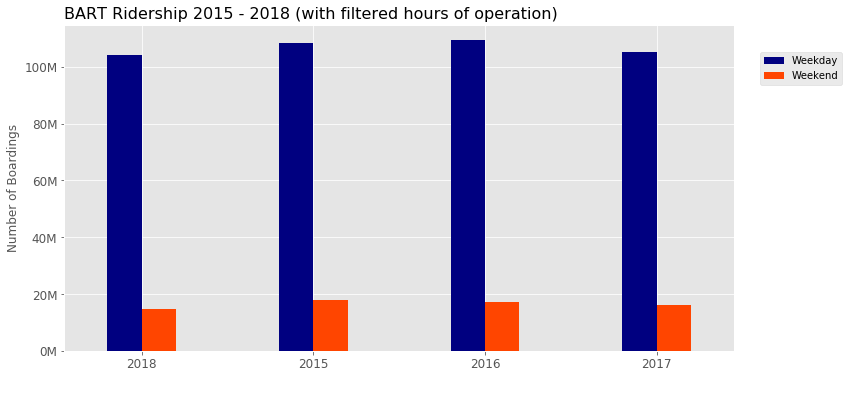

In [42]:
ax = sys_boarding.set_index('year').plot(kind='bar', rot=0, width=0.4, figsize=(12, 6), color=['navy', 'orangered'])
ax.set_title('BART Ridership 2015 - 2018 (with filtered hours of operation)', fontsize=16, loc='left')
ax.set_ylabel('Number of Boardings')
ax.set_xlabel(' ')

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)

# ax.axhline(plot_data['wkday_boarding'].mean(), color='red', linestyle='dashed', linewidth=1)
ax.legend(loc='lower center', bbox_to_anchor=(0.9, 0.8, 0.4, 0.5), shadow=False, ncol=1, labels=['Weekday', 'Weekend'])

pass

### BART Station-level Weekday Passenger Activity (2018) - San Bruno vs Montgomery
- Let's query passenger activities for two stations in the system that have drastically different boarding/alighting behaviors during peak hours

#### SQL query to get passenger activity for San Bruno & Montgomery

In [33]:
# San Bruno
sanbruno_activity_18 = spark.sql(
'''
WITH boardings AS(
    SELECT 
        Hour, 
        SUM(Counts)/COUNT(DISTINCT Date) AS boarding
    FROM 
        bart_15_18
    WHERE 
        Origin = 'SBRN' AND
        Year = 2018 AND
        day_of_week NOT IN ('Saturday', 'Sunday')
    GROUP BY 
        Hour
),
alightings AS 
(
    SELECT
        Hour, 
        SUM(Counts)/COUNT(DISTINCT Date) AS alighting
    FROM 
        bart_15_18
    WHERE 
        Destination = 'SBRN' AND 
        Year = 2018 AND
        day_of_week NOT IN ('Saturday', 'Sunday')
    GROUP BY 
        Hour
)
SELECT 
    b.Hour, 
    b.boarding, 
    a.alighting
FROM
    boardings b 
    LEFT JOIN alightings a
    ON b.Hour = a.Hour
'''
).toPandas()



# Montgomery
montgomery_activity_18 = spark.sql(
'''
WITH boardings AS(
    SELECT 
        Hour, 
        SUM(Counts)/COUNT(DISTINCT Date) AS boarding
    FROM 
        bart_15_18
    WHERE 
        Origin = 'MONT' AND
        Year = 2018 AND
        day_of_week NOT IN ('Saturday', 'Sunday')
    GROUP BY 
        Hour
),
alightings AS 
(
    SELECT
        Hour, 
        SUM(Counts)/COUNT(DISTINCT Date) AS alighting
    FROM 
        bart_15_18
    WHERE 
        Destination = 'MONT' AND 
        Year = 2018 AND
        day_of_week NOT IN ('Saturday', 'Sunday')
    GROUP BY 
        Hour
)
SELECT 
    b.Hour, 
    b.boarding, 
    a.alighting
FROM
    boardings b 
    LEFT JOIN alightings a
    ON b.Hour = a.Hour
'''
).toPandas()

#### Plotly - Passenger activity at San Bruno & Montgomery

In [34]:
data = [sanbruno_activity_18, montgomery_activity_18]
title = [
    'Average Weekday Ridership at San Bruno Station (2018)', 
    'Average Weekday Ridership at Montgomery Station (2018)'
]

plot_data = zip(data, title)


for item in plot_data:
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=item[0]['Hour'],
            y=item[0]['boarding'],
            name='Boarding',
            marker_color='rgb(0, 0, 139)'
            )
    )
    
    fig.add_trace(
        go.Bar(
            x=item[0]['Hour'],
            y=item[0]['alighting'],
            name='Alighting',
            marker_color='rgb(255, 140, 0)'
                        
        )
    )

    fig.update_layout(
        title=item[1],
        xaxis_tickfont_size=12,
        xaxis={
            'title': 'Hour of Day',
            'tickmode': 'linear',
            'titlefont_size': 12,
            'tickfont_size': 12
        },
        yaxis={
            'title': 'Average Daily Boardings',
            'titlefont_size': 12,
            'tickfont_size': 12
        },
        barmode='group'
    )

    fig.update_yaxes(hoverformat=".0f")
    
    fig.show()
    
pass

#### Matplotlib - Passenger activity at San Bruno & Montgomery

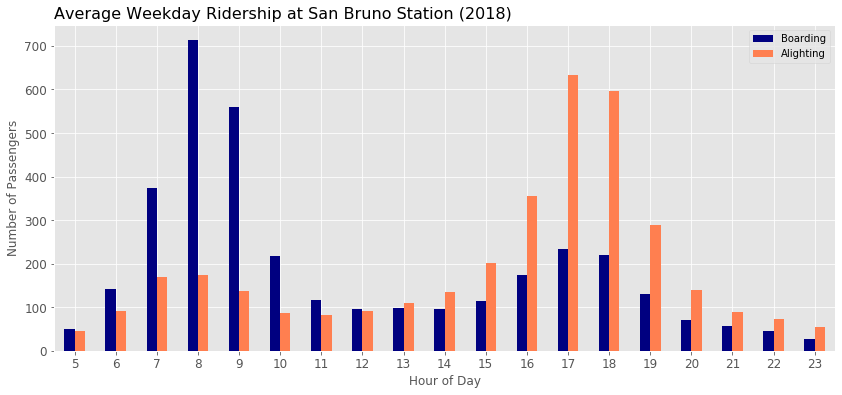

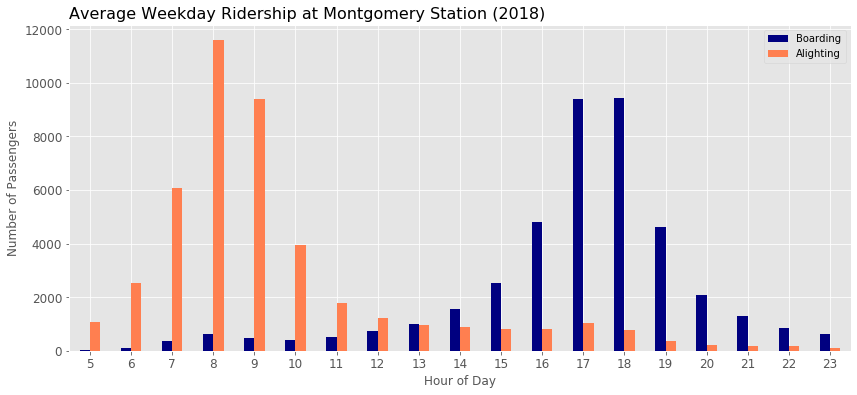

In [35]:
data = [sanbruno_activity_18.sort_values('Hour'), montgomery_activity_18.sort_values('Hour')]
title = ['Average Weekday Ridership at San Bruno Station (2018)', 'Average Weekday Ridership at Montgomery Station (2018)']

plot_data = zip(data, title)

for item in plot_data:
    ax = item[0].plot(
        x='Hour',
        y=['boarding','alighting'], 
        rot=0, 
        kind='bar', 
        figsize=(14,6), 
        color=['navy', 'coral']
    )
    
    ax.set_title(
        item[1],
        fontsize=16,
        loc='left'
    )
    
    ax.set_ylabel('Number of Passengers')
    ax.set_xlabel('Hour of Day')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    ax.legend(['Boarding', 'Alighting'])

pass

#### Lastly, let's join our ridership_15_18_operating DataFrame with our stations DataFrame (twice), so that each origin/destination pair in the dataset can have coordinates attached to both origin and destination stations.
- first, a left join on ridership with stations on ridership.Origin = stations.sta_code
- then, another left join on ridership with stations on ridership.Destinatin = stations.sta_code

In [36]:
ridership_15_18_operating.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Counts: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)



In [37]:
stations.printSchema()

root
 |-- station_name: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- address: string (nullable = true)
 |-- sta_code: string (nullable = true)



#### Now we have a spatial component in our dataset

In [38]:
ridership_15_18_operating.join(
    stations, 
    ridership_15_18_operating.Origin == stations.sta_code,
    'left'
).withColumnRenamed(
    'station_name', 'origin_sta'
).withColumnRenamed(
    'lat', 'origin_lat'
).withColumnRenamed(
    'lon', 'origin_lon'
).drop(
    'Origin', 'address', 'sta_code'
).join(
    stations,
    ridership_15_18_operating.Destination == stations.sta_code,
    'left'
).withColumnRenamed(
    'station_name', 'destination_sta'
).withColumnRenamed(
    'lat', 'destination_lat'
).withColumnRenamed(
    'lon', 'destination_lon'
).drop(
    'Destination', 'address', 'sta_code', 'Hour', 'day_of_week', 'month', 'year'
).show(5)

+----------+------+--------------------+----------+-----------+--------------------+---------------+---------------+
|      Date|Counts|          origin_sta|origin_lat| origin_lon|     destination_sta|destination_lat|destination_lon|
+----------+------+--------------------+----------+-----------+--------------------+---------------+---------------+
|2015-01-01|     1|12th Street / Oak...| 37.803623| -122.27162|        Lake Merritt|       37.79703|     -122.26518|
|2015-01-01|     3| 16th Street Mission| 37.765358| -122.41957|San Francisco Int...|      37.616016|      -122.3925|
|2015-01-01|     2| 19th Street Oakland|  37.80885| -122.26852|San Francisco Int...|      37.616016|      -122.3925|
|2015-01-01|     2|        Civic Center| 37.779575| -122.41371|San Francisco Int...|      37.616016|      -122.3925|
|2015-01-01|     1|   Dublin/Pleasanton|  37.70165|-121.899216|   Montgomery Street|       37.78936|     -122.40133|
+----------+------+--------------------+----------+-----------+-

# Closing

It was fun playing around with the BART ridership data in Spark DataFrame. The [Spark Guide](https://spark.apache.org/docs/2.3.0/sql-programming-guide.html) and [pyspark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.html) covers a whole lot more on what we can do with it. Spark and Pandas DataFrames feels quite similar. On a single node, Pandas DataFrames appear to be more flexible, have better performance, and have more library support, but from exploring the documentation from different versions, I feel that the difference is shrinking. When the dataset is small and scalability is not an issue, Pandas DataFrame will probably serve you well. But since Pandas DataFrames are in-memory and single-server, it is not scalable and is limited by available memory. Spark DataFrame, on the other hand, is limited by the size of the cluster, and thus, horizontally scalable. 

```docker stop your_container```

## Container down, visualization continues
Just out of curiosity as a BART rider on how riders use the rapid transit system in the Bay Area, I loaded BART's 2018 hourly ridership data (filtered from 5AM to midnight) and its stations list data into Tableau and built a visualization containing three dashboards. I also connect the dashbord to a Google Sheet with JavaScript-enabled API request parser to pull relevant information from BART's Station Information API. Here's a sneak peak of the visualization. For better layout and interaction, go [here](https://public.tableau.com/profile/chenlin.ye#!/vizhome/BART_Ridership_2018_cye/StationProfile).

In [43]:
%%HTML
# Embed Link